In [1]:
import pandas as pd
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam

Using TensorFlow backend.
/home/praneet/venv/no_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/praneet/venv/no_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/praneet/venv/no_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/praneet/venv/no_gpu/lib/python3.6/site-pa

In [ ]:
def smoothL1(y_true, y_pred):
    x = K.abs(y_true - y_pred)
    if K._BACKEND == 'tensorflow':
        x = tf.where(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
        return  K.sum(x)

In [4]:
train_csv = pd.read_csv('dataset/training_frames_keypoints.csv').T
test_csv = pd.read_csv('dataset/test_frames_keypoints.csv').T

In [3]:
train_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,3452,3453,3454,3455,3456,3457,3458,3459,3460,3461
Unnamed: 0,Luis_Fonsi_21.jpg,Lincoln_Chafee_52.jpg,Valerie_Harper_30.jpg,Angelo_Reyes_22.jpg,Kristen_Breitweiser_11.jpg,Albert_Brooks_12.jpg,Daniel_Radcliffe_02.jpg,Laura_Bozzo_41.jpg,James_Hoffa_51.jpg,Christopher_Walken_20.jpg,...,Alma_Powell_42.jpg,Kweisi_Mfume_51.jpg,Kurt_Warner_10.jpg,Priyanka_Chopra_51.jpg,Charlotte_Casiraghi_11.jpg,Thomas_Ferguson_02.jpg,Valerie_Harper_00.jpg,Maggie_Smith_00.jpg,Erin_Hershey_Presley_41.jpg,Rocco_Buttiglione_42.jpg
0,45,41,56,61,58,67,35,90,47,126,...,68,34,59,122,59,35,72,52,82,93
1,98,83,69,80,94,134,57,68,101,107,...,78,73,152,93,71,94,133,149,91,134
2,47,43,56,58,58,69,35,88,47,126,...,65,34,66,119,59,35,76,56,82,93
3,106,91,77,95,104,144,62,74,117,122,...,87,82,178,105,84,105,147,160,105,147


In [5]:
img_row = 224
img_col = 224

In [6]:
all_coords = []
images = []
resized_height = 224
resized_width = 224
for i in range(train_csv.shape[1]):
    
    image_name = 'dataset/training/' + train_csv[i][0]
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    og_height, og_width = image.shape
    image = cv2.resize(image, (224, 224))
    images.append(image)
    coordinates = []
    
    if og_height > 224:
        height_ratio = og_height / resized_height
    else:
        height_ratio = resized_height / og_height
    
    if og_width > 224:
        width_ratio = og_width / resized_width
    else:
        width_ratio = resized_width / og_width
    
    for idx in range(0, 136, 2):
        x = int(list(train_csv[i])[1:][idx] * width_ratio)
        y = int(list(train_csv[i])[1:][idx + 1] * height_ratio)
        coordinates.append(x)
        coordinates.append(y)
    
    all_coords.append(np.array(coordinates))
x_train = np.array(images)
del images
x_train = x_train.astype('float32')
x_train /= 255
x_train = np.expand_dims(x_train, axis=4)
y_train = np.array(all_coords)
del all_coords

/home/praneet/venv/no_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [7]:
all_coords = []
images = []
for i in range(test_csv.shape[1]):
    
    image_name = 'dataset/test/' + test_csv[i][0]
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = cv2.resize(image, (224, 224))
    images.append(image)
    
    coordinates = list(test_csv[i])[1:]
    all_coords.append(np.array(coordinates))
x_test = np.array(images)
del images
x_test = x_test.astype('float32')
x_test /= 255
x_test = np.expand_dims(x_test, axis=4)
y_test = np.array(all_coords)
del all_coords

/home/praneet/venv/no_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [8]:
x_test.shape

(770, 224, 224, 1)

In [9]:
model = Sequential()
model.add(Conv2D(64, (3, 3), strides=(1, 1),
                 activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(136))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 128)   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 256)   295168    
__________

In [10]:
model.compile(optimizer = 'adam',loss = 'mean_squared_error', metrics = ['mae','acc'])
model.fit(x_train,y_train,batch_size=32, epochs=2,validation_data=(x_test,y_test))

Train on 3462 samples, validate on 770 samples
Epoch 1/2
3462/3462 [==============================] - 1267s 366ms/step - loss: 3631.7802 - mean_absolute_error: 45.5169 - acc: 0.1456 - val_loss: 1436.7333 - val_mean_absolute_error: 27.8103 - val_acc: 0.6195
Epoch 2/2
3462/3462 [==============================] - 1239s 358ms/step - loss: 1541.0632 - mean_absolute_error: 30.3319 - acc: 0.1687 - val_loss: 1258.6872 - val_mean_absolute_error: 27.4515 - val_acc: 0.6195


In [11]:
image = cv2.imread('dataset/test/Aleksander_Kwasniewski_21.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image, (224, 224))
image = image / 255
image = np.expand_dims(image, axis=4)
image = np.expand_dims(image, axis=0)

# image = image.reshape(-1, 1)

result = model.predict(image)
image.shape

/home/praneet/venv/no_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


(1, 224, 224, 1)

In [12]:
print(result.shape)

(1, 136)


In [13]:
empty = np.zeros((224, 224))

In [23]:
x = list(result[0])[:68]
y = list(result[0])[68:]

In [26]:
coords = zip(x, y)

In [29]:
for x, y in list(coords):
    empty[int(x), int(y)] = 255

In [ ]:
cv2.imshow('title', empty)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
idx = 0
image = cv2.imread('dataset/training/' + train_csv[idx][0], 0)
og_image = image.copy()
resized_image = cv2.resize(image, (224, 224))
x_coords = []
y_coords = []
for a in range(0, 136, 2):
    x_coords.append(int(list(train_csv[idx])[1:][a]))
    y_coords.append(int(list(train_csv[idx])[1:][a + 1]))

In [7]:
resized_image.shape

(224, 224)

In [8]:
og_empty = np.zeros_like(image)
resized_empty = np.zeros(resized_image.shape)

In [9]:
og_height, og_width = og_empty.shape
resized_height, resized_width = resized_image.shape

In [10]:
# width_ratio = og_width / resized_width;
# height_ratio = og_height / resized_height;

width_ratio = resized_width / og_width;
height_ratio = resized_height / og_height;


 
# original_x = int(round(x1 * width_ratio))
# original_y = int(round(y1 * height_ratio))

In [11]:
height_ratio

1.1666666666666667

In [12]:
for i in range(68):
    x = int(round(int(x_coords[i]) * width_ratio))
    y = int(round(int(y_coords[i]) * height_ratio))
    og_image[int(y_coords[i]), int(x_coords[i])] = 255
    og_empty[int(y_coords[i]), int(x_coords[i])] = 255
    resized_image[y, x] = 255
    resized_empty[y, x] = 255

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

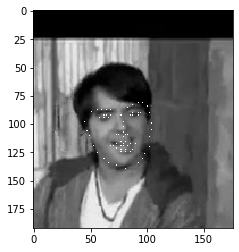

In [14]:
plt.imshow(og_image, cmap='gray')

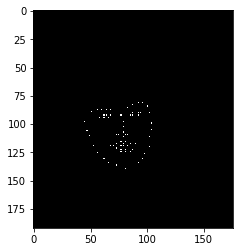

In [15]:
plt.imshow(og_empty, cmap='gray')

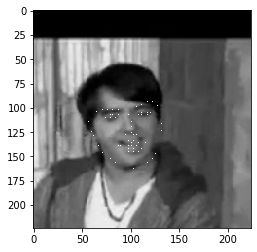

In [16]:
plt.imshow(resized_image, cmap='gray')

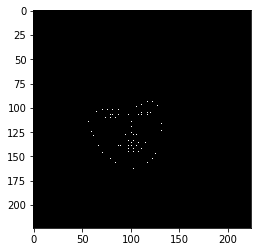

In [17]:
plt.imshow(resized_empty, cmap='gray')